# Activity Classifier

We've explored the data, examined the literature, chosen our features, and pre-processed all the data. Now it's time to finally build the classifier!

In [21]:
import os

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal
import scipy.stats
import itertools

import activity_classifier_utils

Load the data

In [2]:
fs = 256
data = activity_classifier_utils.LoadWristPPGDataset()

### Feature Extraction

Train on 10 second long non-overlapping windows

In [3]:
window_length_s = 10
window_shift_s = 10

In [4]:
import activity_classifier_utils

window_length = window_length_s * fs
window_shift = window_shift_s * fs
labels, subjects, features = [], [], []
for subject, activity, df in data:
    for i in range(0, len(df) - window_length, window_shift):
        window = df[i: i + window_length]
        accx = window.accx.values
        accy = window.accy.values
        accz = window.accz.values
        features.append(activity_classifier_utils.Featurize(accx, accy, accz, fs=fs))
        labels.append(activity)
        subjects.append(subject)

In [5]:
labels = np.array(labels)
subjects = np.array(subjects)
features = np.array(features)

In [6]:
df = pd.DataFrame({'subjects':subjects, '55 Features': np.zeros(len(features)), 'labels':labels})
df['55 Features'] = features.tolist()
df.head().style.hide_index()

subjects,55 Features,labels
s1,"[2.401101684154747, -2.9905948346879363, 8.727178850207967, 0.37551422217316954, 0.43275596026576124, 0.19946448364159933, 1.900888154276325, -3.55852493707656, 8.42109502121394, 1.9581652130525309, -3.483905243307727, 8.472469331587932, 2.071745232073733, -3.3257936235574914, 8.58534210366586, 2.328254244362938, -3.1060451136484293, 8.714974303696055, 2.9134502036080163, -2.3056401268833966, 8.997676355595097, 0.8795605831174862, 0.6961022897630436, 0.7789790786812314, 360.98798349906065, 479.43096613258524, 101.85236540008918, 2.4000000000000004, 1.5, 1.5, 1.5, 0.9980040430837622, 0.000347057221257074, 0.0005404432662970756, 0.0001818396972422001, 0.00017478058269290183, 4.777607983500771e-05, 0.6444567666527556, 0.0002241106899364053, 0.0003489888867392448, 0.00011742219297200658, 0.00011286380047911127, 3.0851195591027105e-05, 0.0764488823316489, 2.6585199583208755e-05, 4.1398914121041746e-05, 1.3929243788168575e-05, 1.3388503075458215e-05, 3.6597325741168576e-06, 0.063841422232309, 2.220093871822636e-05, 3.457167032076243e-05, 1.1632122104800129e-05, 1.1180556887553647e-05, 3.0561929147367564e-06]",bike
s1,"[3.034925716596861, -3.3382791114863877, 8.422790514256718, 0.8110984523191188, 0.5766716860069064, 0.47703003812513994, 1.8550385993108942, -4.133196364217353, 7.94698498538388, 2.267531498771273, -3.9412442507964225, 8.083891522058034, 2.8100740559477138, -3.692649998601104, 8.209289910427467, 3.075226264596894, -3.403290238434443, 8.387389812237902, 3.716350718439919, -2.5468646524357528, 8.88946671464046, 0.31597932553085495, 0.3795787159208438, 0.37616521618271537, 1684.174590347443, 851.3285976116431, 582.5476026206014, 2.5, 1.1, 3.3000000000000003, 1.5, 0.9816070623996411, 0.0043855272690782685, 0.004477616679085894, 0.0019664975123878906, 0.0031478495729359212, 0.003290676504230695, 0.8279340719052455, 0.003698962230837337, 0.0037766348180949903, 0.001658637509028009, 0.002655046010258797, 0.002775513035542351, 0.1317847292830697, 0.0005887748224897152, 0.000601138199275152, 0.00026401026666651956, 0.00042261157206741247, 0.00044178666686450974, 0.10133135815723068, 0.0004527182529890427, 0.0004622246485167591, 0.0002030016606196265, 0.0003249527073699792, 0.0003396967403786135]",bike
s1,"[3.0790489022228793, -3.807686227657727, 8.21607074483946, 0.36482616302200127, 0.3729545648258997, 0.21881545815984818, 2.5348757868993625, -4.321528314937263, 7.876801454205316, 2.621960213254071, -4.248165995825449, 7.9340554981835325, 2.796359940461847, -4.090782787092788, 8.060439289855289, 3.030902253789368, -3.8698816872618638, 8.225040064553873, 3.593520180440893, -3.2596731157284884, 8.464177701976528, 0.7527868181294539, 0.5054113859186535, 0.5740265726203044, 340.731210816911, 356.0834750066592, 122.57332410804293, 0.6000000000000001, 0.6000000000000001, 3.4000000000000004, 3.4000000000000004, 0.9973078972372719, 0.0006619408127742959, 0.0004938060792287918, 0.00034595412494671925, 0.0004575705040904017, 0.00012966287936239234, 0.6535814886947616, 0.00043380009627850787, 0.0003236137137617519, 0.00022671956436837095, 0.00029986688371230985, 8.497401650671952e-05, 0.14099963752473446, 9.358535605960279e-05, 6.981442578731026e-05, 4.891107987092263e-05, 6.469143119941345e-05, 1.833176999917116e-05, 0.10373627803043577, 6.885263456137076e-05, 5.136388157549116e-05, 3.5984868254493306e-05, 4.759479109945888e-05, 1.348705303650462e-05]",bike
s1,"[1.766370410389475, -3.128901028859688, 8.749514657987865, 0.9224807601768269, 0.5865042647468585, 0.5337068770909286, 0.014747179850075998, -4.029985118461834, 7.775580281288904, 0.9933964744032697, -3.7323273409346336, 8.251325439040645, 1.4134688326833966, -3.4547870040353255, 8.56564024186744, 1.756137158337003, -3.1404665631755737, 8.79363716190975, 2.7304967785833565, -2.433638940204648, 9.29585687841388, 0.15953162690242062, 0.008962670978820196, 0.44129790875142405, 2178.485127414826, 880.6073665696077, 729.1981584746279, 0.4, 0.2, 1.5, 1.5

## Build a Random Forest Classifier using sklearn

Let's use sklearn to train a random forest to classify our data.

In [7]:
from sklearn.ensemble import RandomForestClassifier

### Define hyperparameters

Let's build a forest with 100 trees where each tree has a maximum depth of 4

In [8]:
n_estimators = 100
max_tree_depth = 4

### Build and train the model

In [9]:
clf = RandomForestClassifier(n_estimators=n_estimators,
                             max_depth=max_tree_depth,
                             random_state=42)
clf.fit(features, labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=4, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

## Performance Evaluation

### Confusion Matrix

One way to evaluate the performance of a multi-class classifier is to look at a confusion matrix. The confusion matrix shows how many datapoints were misclassified and what they were misclassified as.

In [10]:
from sklearn.metrics import confusion_matrix

Confusion matrix, without normalization
[[0 1 0]
 [1 1 0]
 [0 0 1]]


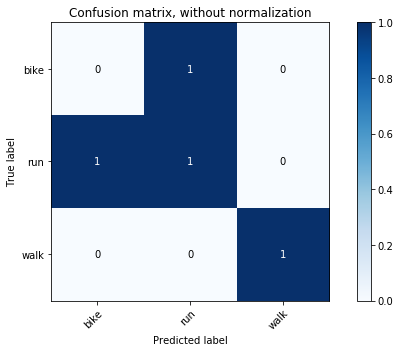

In [11]:
# For illustration purposes lets see how the confusion matrix work for the following example
y_true = ['bike', 'run', 'run', 'walk']
y_pred = ['run', 'run', 'bike', 'walk']
class_names = ['bike', 'run', 'walk']
cm = confusion_matrix(y_true, y_pred, labels=class_names);
activity_classifier_utils.PlotConfusionMatrix(cm, class_names);

### Leave-One-Subject-Out Cross Validation

You may have seen leave-one-out cross validation. Leave-one-subject-out cross validation is similar.

For many biomedical signal applications you have many datapoints per subject. In this case we have 611 datapoints from only 8 subjects. Because there might be a lot of similarity in how an individual performs a specific activity, leaving some of that person's data in the training set and then testing on it might lead us to believe our model generalizes better than it actually would if it encounters a brand new person who it has never seen in the training set. 

For this reason we do leave-one-subject-out cross validation.  This is why we kept track of which subject each datapoint belonged to in the `subjects` array.

In [12]:
from sklearn.model_selection import LeaveOneGroupOut

In [13]:
class_names = np.array(['bike', 'run', 'walk'])
logo = LeaveOneGroupOut()
cm = np.zeros((3, 3), dtype='int')

In [14]:
for train_ind, test_ind in logo.split(features, labels, subjects):
    # For each cross-validation fold...
    
    # Split up the dataset into a training and test set.
    # The test set has all the data from just one subject
    X_train, y_train = features[train_ind], labels[train_ind]
    X_test, y_test = features[test_ind], labels[test_ind]
    
    # Train the classifier
    clf.fit(X_train, y_train)
    
    # Run the classifier on the test set
    y_pred = clf.predict(X_test)
    
    # Compute the confusion matrix for the test predictions
    c = confusion_matrix(y_test, y_pred, labels=class_names)
    
    # Aggregate this confusion matrix with the ones from previous
    # folds.
    cm += c

### Plot Confusion Matrices

In [15]:
class_names = ['bike', 'run', 'walk']

Confusion matrix, without normalization
[[140   1 104]
 [  2 142   3]
 [ 13  18 188]]


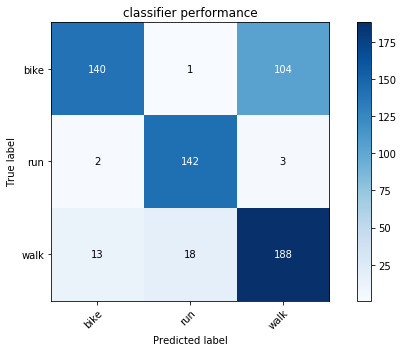

In [16]:
activity_classifier_utils.PlotConfusionMatrix(cm, class_names,
                                              title='classifier performance', normalize=False);

Normalized confusion matrix
[[0.57142857 0.00408163 0.4244898 ]
 [0.01360544 0.96598639 0.02040816]
 [0.05936073 0.08219178 0.85844749]]


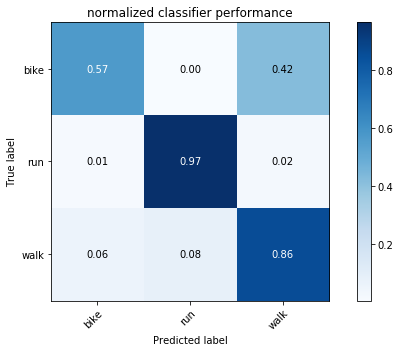

In [17]:
activity_classifier_utils.PlotConfusionMatrix(cm, class_names, 
                                              title='normalized classifier performance',
                                              normalize=True);

We seem to be really good at classifying `run`. We don't really mistake `run` for either `bike` or `walk` and don't misclassify the other classes as `run` often.

Our biggest mistake seems to be misclassifying `bike` as `walk`. We do that 42% of the time.

### Compute Classification Accuracy

An overall measure of classifier performance is the classification accuracy. This is the percent of time that we make a correct classification. There are other metrics to evaluate classifier performance, and using a single metric can be misleading depending on your dataset. See the further resources section for this lesson to learn more.

We can compute the classification accuracy from the confusion matrix as follows

In [29]:
def compute_accuracy(cm):
    """
        Computes accuracy from confusion matrix data
    """
    TP = np.sum(np.diag(cm)) # True positives
    TN = 0; # Our model does not predict if a class is negative
    Total = np.sum(cm) # total number of samples
    return (TP+TN)/Total

In [30]:
print(f"Accuracy of our Random Forest model is: {compute_accuracy(cm)}")

Accuracy of our Random Forest model is: 0.7463175122749591


# Hyper parameter Fine-tunning

In [41]:
# Hyper parameters to fine-tune
n_estimators_opt = [2, 10, 20, 50, 100, 150, 300]
max_tree_depth_opt = range(2, 7)

In [35]:
class_names = np.array(['bike', 'run', 'walk'])
logo = LeaveOneGroupOut()
accuracy_table = []

for n_estimators, max_tree_depth in itertools.product(n_estimators_opt, max_tree_depth_opt):
    # Iterate over each pair of hyperparameters
    cm = np.zeros((3, 3), dtype='int')                       # Create a new confusion matrix
    clf = RandomForestClassifier(n_estimators=n_estimators,  # and a new classifier  for each
                                 max_depth=max_tree_depth,   # pair of hyperparameters
                                 random_state=42,
                                 class_weight='balanced')
    for train_ind, test_ind in logo.split(features, labels, subjects):
        # Do leave-one-subject-out cross validation as before.
        X_train, y_train = features[train_ind], labels[train_ind]
        X_test, y_test = features[test_ind], labels[test_ind]
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        c = confusion_matrix(y_test, y_pred, labels=class_names)
        cm += c
    # For each pair of hyperparameters, compute the classification accuracy
    classification_accuracy = compute_accuracy(cm)
    
    # Store the hyperparameters and the classification accuracy that resulted
    # from the model created with them.
    accuracy_table.append((n_estimators, max_tree_depth, classification_accuracy))

In [36]:
accuracy_table_df = pd.DataFrame(accuracy_table,
                                 columns=['n_estimators', 'max_tree_depth', 'accuracy'])
accuracy_table_df

,n_estimators,max_tree_depth,accuracy
0,2,2,0.787234
1,2,3,0.605565
2,2,4,0.687398
3,10,2,0.746318
4,10,3,0.693944
5,10,4,0.689034
6,100,2,0.891980
7,100,3,0.780687
8,100,4,0.782324
9,150,2,0.893617


In [37]:
# Best combination of parameters is:
accuracy_table_df.loc[accuracy_table_df.accuracy.idxmax()]

n_estimators      150.000000
max_tree_depth      2.000000
accuracy            0.893617
Name: 9, dtype: float64

**Conclusion** This means that the combination of hyper-parameters is `max_tree_depth=2` and `n_estimators=150` which yields an accuracy of 89.36% 

`Note` The issue with this approach is that we are making hyper-parameter decisions based on the testing dataset, which might be a biased approach. To mitigate this problem we need to create a validation dataset. 

## Nested Cross validation

Nested cross validation is equivalent to dividing the dataset into `train`, `validation` and `test` sets, but when we don't have enough data to separate your dataset into 3 parts, we can nest the hyperparameter selection in another layer of cross-validation.

In [42]:
class_names = ['bike', 'run', 'walk']

# Store the confusion matrix for the outer CV fold.
nested_cv_cm = np.zeros((3, 3), dtype='int')
splits = 0

for train_val_ind, test_ind in logo.split(features, labels, subjects):
    # Split the dataset into a test set and a training + validation set.
    # Model parameters (the random forest tree nodes) will be trained on the training set.
    # Hyperparameters (how many trees and the max depth) will be trained on the validation set.
    # Generalization error will be computed on the test set.
    X_train_val, y_train_val = features[train_val_ind], labels[train_val_ind]
    subjects_train_val = subjects[train_val_ind]
    X_test, y_test = features[test_ind], labels[test_ind]
    
    # Keep track of the best hyperparameters for this training + validation set.
    best_hyper_parames = None
    best_accuracy = 0
    
    for n_estimators, max_tree_depth in itertools.product(n_estimators_opt,
                                                          max_tree_depth_opt):
        # Optimize hyperparameters as above.
        inner_cm = np.zeros((3, 3), dtype='int')
        clf = RandomForestClassifier(n_estimators=n_estimators,
                                     max_depth=max_tree_depth,
                                     random_state=42,
                                     class_weight='balanced')
        for train_ind, validation_ind in logo.split(X_train_val, y_train_val,
                                                    subjects_train_val):
            X_train, y_train = X_train_val[train_ind], y_train_val[train_ind]
            X_val, y_val = X_train_val[validation_ind], y_train_val[validation_ind]
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_val)
            c = confusion_matrix(y_val, y_pred, labels=class_names)
            inner_cm += c
        classification_accuracy = compute_accuracy(inner_cm)
        
        # Keep track of the best pair of hyperparameters.
        if classification_accuracy > best_accuracy:
            best_accuracy = classification_accuracy
            best_hyper_params = (n_estimators, max_tree_depth)
    
    # Create a model with the best pair of hyperparameters for this training + validation set.
    best_clf = RandomForestClassifier(n_estimators=best_hyper_params[0],
                                      max_depth=best_hyper_params[1],
                                      class_weight='balanced')
    
    # Finally, train this model and test it on the test set.
    best_clf.fit(X_train_val, y_train_val)
    y_pred = best_clf.predict(X_test)
    
    # Aggregate confusion matrices for each CV fold.
    c = confusion_matrix(y_test, y_pred, labels=class_names)
    nested_cv_cm += c
    splits += 1
    print('Done split {}'.format(splits))


Done split 1
Done split 2
Done split 3
Done split 4
Done split 5
Done split 6
Done split 7
Done split 8


In [44]:
print(best_clf)
# Getting accuracy on the testing set
compute_accuracy(nested_cv_cm)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


0.7741407528641571

**Conclusion** We can see that by assessing our model on a completely new set (testing dataset) our model doesn't perform as good as we thought in the previous section.

## Best features-only regularization 

Now that we have a correct way of assessin our model. We can try to improve it for now on. One of the best ways to regularized a model that has too features fed to it is to take into account only best features or features that are more relevant for the target we are looking for. 

In [47]:
# let's see what are the ratings for each performance (the higher the value the higher the importance)
best_clf.feature_importances_

array([0.00000000e+00, 3.75397406e-03, 1.72506479e-02, 3.01881206e-03,
       7.76452151e-02, 2.46097823e-02, 4.61399226e-02, 4.51495067e-03,
       5.32232331e-02, 4.45441489e-02, 1.60339468e-04, 1.06337275e-01,
       0.00000000e+00, 1.33560334e-03, 6.21122805e-02, 0.00000000e+00,
       7.73482982e-03, 1.09810744e-02, 1.07627208e-04, 3.85087396e-03,
       2.83927151e-03, 2.76103709e-03, 0.00000000e+00, 2.58902819e-05,
       1.35249890e-02, 5.44956687e-02, 3.62204949e-02, 0.00000000e+00,
       4.03505305e-04, 0.00000000e+00, 0.00000000e+00, 2.79199938e-02,
       2.06116699e-02, 3.46338789e-03, 7.47846207e-03, 2.15228900e-03,
       0.00000000e+00, 2.60237011e-03, 3.52552354e-03, 2.96951276e-03,
       5.43172420e-03, 9.28130718e-05, 1.18046372e-04, 1.66057621e-02,
       1.11270428e-01, 4.56373468e-02, 6.86592388e-02, 4.51069628e-02,
       2.77443382e-02, 0.00000000e+00, 5.97030305e-03, 7.29757063e-04,
       6.52217608e-03, 9.54638770e-03, 8.25005899e-03])

In [48]:
# get the 10 most important features
sorted(list(zip(best_clf.feature_importances_, activity_classifier_utils.FeatureNames())), reverse=True)[:10]

[(0.11127042795488563, 'energy_12_z'),
 (0.10633727547190319, 'p10_z'),
 (0.07764521508236992, 'std_y'),
 (0.06865923880937809, 'energy_34_z'),
 (0.06211228049770109, 'p25_z'),
 (0.05449566872945236, 'energy_y'),
 (0.053223233116716756, 'p5_z'),
 (0.046139922592014576, 'p5_x'),
 (0.04563734683260797, 'energy_23_z'),
 (0.04510696282999904, 'energy_45_z')]

In [91]:
sorted_features = sorted(zip(best_clf.feature_importances_, np.arange(len(best_clf.feature_importances_))), 
                         reverse=True)
best_feature_indices = list(zip(*sorted_features))[1]
X = features[:, best_feature_indices[:10]] # Data with only the 10 best features
X.shape

(611, 10)

Normalized confusion matrix
[[0.92653061 0.07346939 0.        ]
 [0.05022831 0.87671233 0.07305936]
 [0.01360544 0.04081633 0.94557823]]
Classification accuracy = 0.91


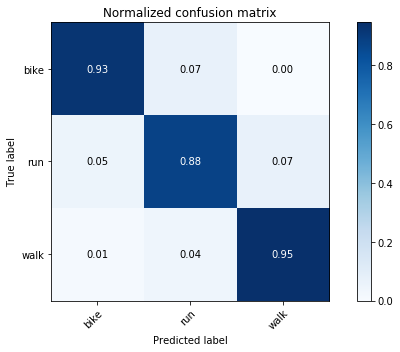

In [92]:
cm = activity_classifier_utils.LOSOCVPerformance(X, labels, subjects, best_clf)
activity_classifier_utils.PlotConfusionMatrix(cm, class_names, normalize=True)
print('Classification accuracy = {:0.2f}'.format(compute_accuracy(cm)))

In [93]:
class_names = ['bike', 'run', 'walk']

# Store the confusion matrix for the outer CV fold.
nested_cv_cm = np.zeros((3, 3), dtype='int')
splits = 0

for train_val_ind, test_ind in logo.split(X, labels, subjects):
    # Split the dataset into a test set and a training + validation set.
    # Model parameters (the random forest tree nodes) will be trained on the training set.
    # Hyperparameters (how many trees and the max depth) will be trained on the validation set.
    # Generalization error will be computed on the test set.
    X_train_val, y_train_val = features[train_val_ind], labels[train_val_ind]
    subjects_train_val = subjects[train_val_ind]
    X_test, y_test = features[test_ind], labels[test_ind]
    
    # Keep track of the best hyperparameters for this training + validation set.
    best_hyper_parames = None
    best_accuracy = 0
    
    for n_estimators, max_tree_depth in itertools.product(n_estimators_opt,
                                                          max_tree_depth_opt):
        # Optimize hyperparameters as above.
        inner_cm = np.zeros((3, 3), dtype='int')
        clf = RandomForestClassifier(n_estimators=n_estimators,
                                     max_depth=max_tree_depth,
                                     random_state=42,
                                     class_weight='balanced')
        for train_ind, validation_ind in logo.split(X_train_val, y_train_val,
                                                    subjects_train_val):
            X_train, y_train = X_train_val[train_ind], y_train_val[train_ind]
            X_val, y_val = X_train_val[validation_ind], y_train_val[validation_ind]
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_val)
            c = confusion_matrix(y_val, y_pred, labels=class_names)
            inner_cm += c
        classification_accuracy = compute_accuracy(inner_cm)
        
        # Keep track of the best pair of hyperparameters.
        if classification_accuracy > best_accuracy:
            best_accuracy = classification_accuracy
            best_hyper_params = (n_estimators, max_tree_depth)
    
    # Create a model with the best pair of hyperparameters for this training + validation set.
    best_clf = RandomForestClassifier(n_estimators=best_hyper_params[0],
                                      max_depth=best_hyper_params[1],
                                      class_weight='balanced')
    
    # Finally, train this model and test it on the test set.
    best_clf.fit(X_train_val, y_train_val)
    y_pred = best_clf.predict(X_test)
    
    # Aggregate confusion matrices for each CV fold.
    c = confusion_matrix(y_test, y_pred, labels=class_names)
    nested_cv_cm += c
    splits += 1
    print('Done split {}'.format(splits))

Done split 1
Done split 2
Done split 3
Done split 4
Done split 5
Done split 6
Done split 7
Done split 8


In [94]:
print(best_clf)
# Getting accuracy on the testing set
compute_accuracy(nested_cv_cm)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


0.7970540098199672

**Final Conclusion** By regularizing on best features only we were able to achieve a 91% accuracy for the normal evaluation and around 80% for the nested cross validation. 